# Music Recommender System

## ISI Delhi ( Remote ) Summer Internship Project
### By Umesh Yadav ( 2018UCS0078 ), CSE Department, IIT Jammu
#### Contact: 2018usc0078@gmail.com
### Under Supervision of Prof. Samir Kumar Neogy, Prof. & Head, ISI Delhi
#### Contact : skn@isid.ac.in


# Introduction

In this Project, I have used (a Subset) of *Million Song Dataset (MSD)*, Provided by [turi.com](https://static.turi.com/datasets/millionsong/10000.txt) which is taken from a subset of *The Echo Nest Taste Profile Subset* from [here](http://millionsongdataset.com/tasteprofile). It contains triplets of **(user_id, song_id, listen_count)** and has been provided in a text file with triplets being seperated by *'/t' (tab)*.
Song metadata consisting of features related to song wasn't available anywhere except the official [site](http://millionsongdataset.com) of *MSD*. I have downloaded the summary file of the whole 280GB Dataset. It was in .h5 format and I used utility ( edited it alot for my own specific requirements ) from [GitHub](https://github.com/AGeoCoder/Million-Song-Dataset-HDF5-to-CSV) to convert that md5 file into .csv file. It contains metadata for **Unique 10k Songs** contained in triplets file of MSD.

I have used this dataset to train and evaluate the Recommender System using four Algorithms:
1. **Popularity Model:** Sort the Songs according to their Popularity Score.
2. **KNN Model:** Aggregate Similar Songs according to their features or Metadata.
3. **Collaborative Filtering ( Memory Based ) Model:**
    1. **Item-Item CF Model:** Find Similar Songs according to the No. of Users who have rated/ listened them
        1. **Jaccard Based Score:** Sorted Songs according to the Jaccard Index/ Score ( More Info [here](https://en.wikipedia.org/wiki/Jaccard_index) or given in the report of this project )
        2. **Conditional Probability Score:** Sorted according to the Score obtained using Conditional Probability ( More Info [here](http://www.ke.tu-darmstadt.de/events/PL-12/papers/08-aiolli.pdf) or given in the report of this project )
    2. **User-User CF Model:** Find Similar Songs according to the No. of Songs listened by Similar Users
        1. **Jaccard Based Score:** Sorted Songs according to the Jaccard Index/ Score ( More Info [here](https://en.wikipedia.org/wiki/Jaccard_index) or given in the report of this project )
        2. **Conditional Probability Score:** Sorted according to the Score obtained using Conditional Probability ( More Info [here](http://www.ke.tu-darmstadt.de/events/PL-12/papers/08-aiolli.pdf) or given in the report of this project )
4. **Latent Factors ( SVD ) Model:** Find the latent factors of User and Songs by using SVD on User_Song Rating (Implicit Rating) Matrix.

So, **Our Objective using above Models / Algorithms is to return an *Ordered (Ranked) List of Songs* that we call Recommendation List using the Listening History of the User** and Obviously, we must not recommend a user, the songs which he/she has already listened to and hence, our Recommendation List contains only Recommendations for our User with no Songs already listened by them.

## Let's Begin

First take a Glance on the Data that we have for our Music Recommender System.

In [1]:
#Importing Required Packages
import pandas as pd
import numpy as np
# import joblib
from sklearn.model_selection import train_test_split
import Rec as Recommenders
import importlib
importlib.reload(Recommenders)
import utility_script as utility
import importlib
importlib.reload(Recommenders)
from scipy.sparse import csc_matrix
import pickle
import Evaluation as Evaluation
# import Evaluation as Evaluation

In [2]:
# Read songs metadata
songs_metadata = pd.read_csv(r'./data/original/songs_metadata.csv')

In [3]:
# Read (user_id, song_id, listen_count) triplets data
# File has been downloaded from https://static.turi.com/datasets/millionsong/10000.txt
# Which is a subset of The Echo Nest Taste Profile Subset from http://millionsongdataset.com/tasteprofile
users_data = pd.read_fwf(r'./data/original/users_data.txt')

In [4]:
# Create Pandas DataFrame from songs metadata
songs_metadata = pd.DataFrame(songs_metadata)
songs_metadata

,song_id,release,release_7digitalid,artist_id,artist_name,artist_hotttnesss,duration,key_confidence,loudness,mode_confidence,song_hotttnesss,tempo,time_signature_confidence,title,track_id,year
0,SOSZNRJ12A8AE46E38,Juno - Music From The Motion Picture,186998,AR62GN71187B9AAD0C,Michael Cera & Ellen Page,0.464981,116.71465,0.819,-12.947,0.629,NaN,145.921,0.401,Anyone Else But You,TRMMCDR128F423AB03,2007
1,SOGKGLB12A81C22AFA,Graduation,131059,ARRH63Y1187FB47783,Kanye West / Mos Def,1.082503,313.28608,0.812,-7.750,0.768,NaN,165.589,1.000,Drunk and Hot Girls,TRMMFSL128F4234583,2007
2,SOWZDNH12A6D4F7237,Page Avenue,44099,ARF6ZTO1187FB3684F,Story Of The Year,0.580095,235.78077,0.245,-4.103,0.380,0.470560,183.976,0.535,Until The Day I Die (Album Version),TRMMQSP128F1486267,2003
3,SOQBGZD12AB0184341,Riot!,512467,AR4OU721187FB4549D,Paramore,0.658925,226.95138,0.420,-5.120,0.543,0.726918,96.135,0.301,Rewind (Demo),TRMMQOL128F9340687,0
4,SOTPWHK12A8AE46DC8,Love Songs,299449,ARWPYQI1187FB4D55A,Rick Astley,0.507464,185.67791,0.615,-5.471,0.513,0.480611,120.074,0.540,Never Knew Love,TRMMZKU128F4296801,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,SOKGVJH12A58A77920,Rubber Factory,556606,ARS8GNX1187B9B5141,The Black Keys,0.741724,147.93098,0.089,-5.114,0.577,0.809308,86.709,0.661,Grown So Ugly,TRYYJHJ128F9340B19,2004
9996,SOINBEP12AB017FEE1,Rules,411787,AR5NQPT1187FB45A43,The Whitest Boy Alive,0.502305,423.49669,0.450,-9.291,0.639,0.837390,83.041,1.000,Island,TRYYJQY128F9320622,2009
9997,SOETNKM12A8AE47EEA,"The Shepherd's Dog""""",135301,AR4XX0N1187FB45C21,Iron And Wine,0.535342,261.82485,0.180,-8.754,0.314,0.820511,117.137,0.530,House By the Sea (Album),TRYYDLF128F423BB17,2007
9998,SOKATLY12A8C132FE2,The Score,284274,ARGYWM01187B98DB75,Fugees,0.514986,260.12689,0.570,-10.944,0.469,NaN,89.962,1.000,FU-GEE-LA,TRYYONN128F426A856,1996


In [5]:
# Fill NaN or missing values by Mean Value of the Column of songs metadata
songs_metadata.fillna(songs_metadata.mean(), inplace=True)

# Columnwise Statistical Analysis of songs_metadata
songs_metadata.describe()

,release_7digitalid,artist_hotttnesss,duration,key_confidence,loudness,mode_confidence,song_hotttnesss,tempo,time_signature_confidence,year
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,292757.994300,0.562495,248.918150,0.45785,-8.034781,0.492390,0.715694,125.165801,0.559688,1645.790700
std,235662.258444,0.131789,98.301002,0.27146,3.900603,0.189487,0.156077,32.700260,0.362232,764.117466
min,20.000000,0.000000,11.989750,0.00000,-39.217000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,62241.000000,0.488339,200.646080,0.24600,-9.823500,0.378000,0.669003,100.027000,0.234000,1984.000000
50%,274648.000000,0.549302,235.519550,0.47800,-7.153000,0.503000,0.716719,122.816000,0.620000,2002.000000
75%,476071.000000,0.607257,277.975060,0.65800,-5.316000,0.621000,0.810360,145.917250,0.902250,2007.000000
max,823416.000000,1.082503,3024.665670,1.00000,1.421000,1.000000,1.000000,260.231000,1.000000,2010.000000


In [6]:
# Add Columns to the user triplets data
users_data.columns = ['user_id', 'song_id', 'listen_count']

# Create Pandas DataFrame from user triplets data
users_data = pd.DataFrame(users_data)
users_data

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5
...,...,...,...
1999994,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1


In [7]:
# No. of Unique Users in the users triplets Dataset
users = list(users_data["user_id"].unique())
print("Unique Users in the users triplets Dataset:", len(set(users_data["user_id"])))

# No. of Unique Songs in the users triplets Dataset
songs = list(users_data["user_id"].unique())
print("Unique Songs in the users triplets Dataset:", len(set(users_data["song_id"])))

# No. of Unique Songs in the songs metadata Dataset
print("Unique Songs in the songs metadata Dataset:", len(set(songs_metadata["song_id"]))) 

Unique Users in the users triplets Dataset: 76353
Unique Songs in the users triplets Dataset: 10000
Unique Songs in the songs metadata Dataset: 10000


In [8]:
# Merge user_data and song_data to visulaize the DataFrame
data = pd.merge(users_data, songs_metadata.drop_duplicates(["song_id"]), how="left", on="song_id")
# data = data.head(100000)
data

,user_id,song_id,listen_count,release,release_7digitalid,artist_id,artist_name,artist_hotttnesss,duration,key_confidence,loudness,mode_confidence,song_hotttnesss,tempo,time_signature_confidence,title,track_id,year
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Flamenco Para Ni\xc3\xb1os,241239,ARC1SF21187FB51D0F,Paco De Lucia,0.417718,358.24281,0.745,-7.164,0.724,0.735295,192.975,0.392,Entre Dos Aguas,TRMHBXZ128F4238406,1976
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Graduation,130573,ARRH63Y1187FB47783,Kanye West,1.082503,311.84934,0.183,-8.394,0.180,0.715694,138.570,1.000,Stronger,TRHNCIR128F42334A5,2007
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,In Between Dreams,221729,ARC8CQZ1187B98DECA,Jack Johnson,0.694129,201.63873,0.051,-12.595,0.453,0.785447,121.868,0.277,Constellations,TRYBNIB128F428E704,2005
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,There Is Nothing Left To Lose,298758,AR6XPWV1187B9ADAEB,Foo Fighters,0.550762,235.28444,0.699,-4.128,0.855,0.986142,136.099,0.764,Learn To Fly,TRKRHYM128F42934A9,1999
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,Antolog\xc3\xada Audiovisual,19998,AR3SPD91187B9B63E3,H\xc3\xa9roes del Silencio,0.524063,231.36608,0.376,-4.555,0.536,0.715694,169.836,0.377,"Apuesta Por El Rock 'N' Roll""""",TRPTWGR128F1452734,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999994,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2,Ignorance,528820,AR4OU721187FB4549D,Paramore,0.658925,218.09587,0.619,-2.829,0.523,1.000000,170.970,0.921,Ignorance (Album Version),TRGQGIM128F92F438F,0
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4,Love Drunk,565820,ARG72Q21187FB36243,Boys Like Girls featuring Taylor Swift,0.587033,242.83383,0.599,-5.468,0.628,0.853353,127.987,0.553,Two Is Better Than One,TRAWVYP128F9305DF2,2009
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3,"What I've Done""""",81728,ARQUMH41187B9AF699,Linkin Park,0.791143,208.92689,0.752,-5.109,0.488,1.000000,120.065,0.792,"What I've Done (Album Version)""""",TRTWFKE128EF35F93B,2007
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1,My Worlds,767482,ARFCWSZ123526A0AFD,Justin Bieber,0.691249,234.91873,0.557,-4.560,0.545,0.809942,125.944,0.886,Up,TRZAVEC12903CD2DD2,2010


In [9]:
# Print the Length of the merged Dataset
print(len(data))

1999999


## Randomly Split Dataset into Train and Test Data 

Our Data Contains about **76k Unique Users and 10k Unique Songs and their Listen Count alongwith Song Metadata**. Each User in the Dataset has listened to a Song in the Past i.e every User has Listen Count >0 and thus, each Song has been listened atleast once. 

Let us split the Data into Train Data (80%) and Test Data (20%). So that we can Train, Evaluate and Compare our various Models.

In [10]:
# Randomly split data into train (80%) and test (20%) data with seed = 0
train_data, test_data = train_test_split(data, test_size = 0.20, random_state=0)

In [11]:
# Unique Users in train_data Dataset
train_users = list(train_data["user_id"].unique())
print("No. of Unique Users in train_data Dataset:", len(train_users))

# Unique Songs in the train_data Dataset
train_songs = list(train_data["song_id"].unique())
print("No. of Unique Songs in train_data Dataset:", len(train_songs))

# Unique Users in the test_data Dataset
test_users = list(test_data["user_id"].unique())
print("No. of Unique Users in test_data Dataset:", len(test_users))

# Unique Songs in the test_data Dataset
test_songs = list(test_data["song_id"].unique())
print("No. of Unique Songs in test_data Dataset:", len(test_songs))

# Unique Common Users in train_data and test_data Dataset
common_users = list(set(test_users).intersection(set(train_users)))
print("No. of Unique Common Users in train_data and test_data Dataset:", len(common_users))

# Unique Common Songs in train_data and test_data Dataset
common_songs = list(set(test_songs).intersection(set(train_songs)))
print("No. of Unique Common Songs in train_data and test_data Dataset:", len(common_songs))

No. of Unique Users in train_data Dataset: 76104
No. of Unique Songs in train_data Dataset: 10000
No. of Unique Users in test_data Dataset: 68637
No. of Unique Songs in test_data Dataset: 10000
No. of Unique Common Users in train_data and test_data Dataset: 68388
No. of Unique Common Songs in train_data and test_data Dataset: 10000


## Normalising Songs Metadata

Features or Metadata of Songs in our Dataset contain varying values with different scales or ranges. Some of the Features are string and thus needed to be dropped for the Normalisation so that we can fit our KNN Model on the Train Set. Also, Songs Metadata is not much useful for other Techniques/ Models discussed below and hence we should irrelevant features from our Dataset.

In [12]:
# Extracting Unique Songs Metadata from train_data Dataset
train_songs_df = train_data.drop_duplicates(['song_id'])

# Extracting Unique Songs Metadata from test_data Dataset
test_songs_df = test_data.drop_duplicates(['song_id'])

# Dropping not needed features from train and test Songs Metadata
drop_features_songs = ["user_id","song_id","release","release_7digitalid","artist_id","artist_name","title","track_id"]
train_songs_metadata = train_songs_df.drop(drop_features_songs, axis=1)
test_songs_metadata = test_songs_df.drop(drop_features_songs, axis=1)

In [13]:
# Dropping not needed features from train_data and test_data Datasets
data = data[['user_id','song_id','title','listen_count']]
train_data = train_data[['user_id','song_id','title','listen_count']]
test_data = test_data[['user_id','song_id','title','listen_count']]

# Saving the cleaned dataset (in pickle i.e .pkl file format) for future computations
data.to_pickle("./data/data.pkl")
train_data.to_pickle("./data/train_data.pkl")
test_data.to_pickle("./data/test_data.pkl")

In [14]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(train_songs_metadata)

# transform training data
train_songs_metadata_norm = norm.transform(train_songs_metadata)

# transform testing data
test_songs_metadata_norm = norm.transform(test_songs_metadata)

In [15]:
# Loading the Cleaned Dataset for Training and Testing Our Models.
data = pd.read_pickle("./data/data.pkl")
train_data = pd.read_pickle("./data/train_data.pkl")
test_data = pd.read_pickle("./data/test_data.pkl")

## Import Utilities

While doing the code, I realised that there are few things about our Dataset which is required in Training and Testing of the Models that we are going to implement. So, I prepared a Script (which can be found in the root folder of this Project) to generate:

1. **Utility Dictionary**: Python Dictionary (Hash Table) containing Dictionaries of:
    1. **Songs_to_Users (s2u) Mapping**: Key as Song and Value as List of Listeneres of that Song
    2. **Users_to_Songs (u2s) Mapping**: Key as User and Value as List of Songs User has listened
    3. **Songs_to_Titles (s2t) Mapping**: Key as Song and Value as Title of that Song
    4. **Songs_to_Index (s2i) Mapping**: Key as Song and Value as Index of that Song
    5. **Users_to_Index (u2i) Mapping**: Key as Song and Value as Index of that Song
    6. **Songs (songs) Mapping**: List of all Unique Songs
    7. **Users (users) Mapping**: List of all Unique Users


2. **Rating Matrix(M)**: *Sparse Matrix* of order **(no. of users x no. of songs)** with $M_{ij}= 1$ **if User i has listened to Song j otherwise 0**. This is what we call **Implicit Feedback or Implicit Rating**. It is this Spase Nature of this Matrix (Implicit Feedback i.e No Rating Given by User) which makes this problem really Challenging.

In [16]:
# Import Utility Functions/ Mappings from utility_script
import utility_script as utility

util_dict = utility.gen_util_dict()
data_util_dict = util_dict["data"]
train_util_dict = util_dict["train_data"]
test_util_dict = util_dict["test_data"]

## Popularity Model

As the Name Suggests, this Model is a naive approach for recommending the Most Popular Songs (sorted by their percentage of listen count indicating their popularity) to the User. After sorting them by their popularity, we remove songs already listened by the User from Recommendation List.<br> There is no personalisation involved in this Model which can be confirmed below as our Model will recommend same popular songs to all the users. However, It is very helpful in the case when our Users are Guest Users, those who don't share any Preferences or Information about themselves about which song they like or not and hence, these models can help make our Recommender Systems Smart by even recommending something *Trending* to the Users to listen to (better than recommending nothing :))

In [17]:
# Create Popularity Model Instance
popularity_model = Recommenders.popularity_recommender()
popularity_model.create(train_util_dict)

In [18]:
# Get Recommendations for a User
popularity_model.recommend(test_users[50])

,song_id,title,listen_count,score
2220,SOFRQTD12A81C233C0,Sehr kosmisch,6612,0.413250
317,SOAUWYT12A81C206F1,Undo,5647,0.352938
352,SOAXGDH12A8C13F8A1,Dog Days Are Over (Radio Edit),5485,0.342813
614,SOBONKR12A58A7A7E0,"You're The One""""",5085,0.317813
7416,SOSXLTC12AF72A7F54,Revelry,4952,0.309500
...,...,...,...,...
7289,SOSNOSA12A67ADA05B,Woman,390,0.024375
7754,SOTUARP12A8C13CB54,Rio,390,0.024375
4596,SOLOZRE12A8C133256,M79 (Album),389,0.024313
6636,SOQTPLM12B0B809575,Strange Times,389,0.024313


### Calculation of mAP@500 score for Popularity Model

Using mAP (Mean Average Precision) to evaluate a recommender algorithm implies that we are treating the recommendation like a ranking task. This often makes perfect sense because a user has a finite amount of time and attention and we want to show the top recommendations first and maybe market them more aggressively. We have used it as percentage i.e in %.<br>
A recommender system typically produces an ordered list of recommendations for each user in the test set. mAP gives insight into how relevant the list of recommended items are. The Higher the mAP score, the Better is our Recommender System.

In [19]:
%%time
# Calcuate mAP@500 for test Sample
mAP_at_tau = Evaluation.maptau(popularity_model, common_users, test_util_dict, sampling_rate=0.3, tau=500)
print("---------------------------------")
print("mAPat500 for test sample is:", mAP_at_tau, "%")
print("---------------------------------")

Length of user_test_and_training:68388
Length of user sample:20516
1 0.3153779897965944 %
10001 2.7252125005106373 %
20001 2.624632763284519 %
20516 2.6147447408969695 %
---------------------------------
mAPat500 for test sample is: 2.6147447408969695 %
---------------------------------
CPU times: user 1min 5s, sys: 1.04 s, total: 1min 6s
Wall time: 1min 11s


## $K$ Nearest Neighbors ( $K$NN ) Model

Songs in our Dataset have a limited (or rather very few) amount of Metadata associated with each song and this make it a tough job for KNN to figure the most similar Songs among the available Dataset. This Algorithm returns two ordered Lists namely Indices and Distances after single pass through our songs metadata (training data) (after Normalisation) which contains the indices of Songs which are most similar to the given songs, sorted in order w.r.t the distances between them calculated using [Ball Tree](https://scikit-learn.org/stable/modules/neighbors.html) Algorithm in which *The number of candidate points for a neighbor search is reduced through use of the triangle inequality.* From these Indices and Distances, I have assigned a *Score (equal to -ve of the distance value)* to each Recommended Song and then after removing the songs already listened by the user, Sorted the Final Recommended Songs as per their Scores (in reverse Order) for the final Recommendations. More Detail about the implementation can be understood using/ through the Code provided in root folder of this Project.<br>


In [20]:
# Create KNN Model Instance
knn_model = Recommenders.knn_recommender()
knn_model.create(train_songs_metadata_norm,train_util_dict,n_neighbors=10)

In [21]:
# Get Recommendations for a User
knn_model.recommend(test_users[10])

,song_id,title,score
0,SOPRFNT12AB017F8E9,Genie In A Bottle,-0.092336
1,SOFKYDZ12AB017F425,Stadium Love,-0.094529
2,SOFHEAN12AB018A760,Drugs,-0.108188
3,SORRBVQ12A58A7AA33,Change,-0.113325
4,SOVMSAW12A6D4F95A4,Mount Wroclai (Idle Days),-0.116675
...,...,...,...
67,SOODRHW12A6310D8FF,Rent,-0.334263
68,SOODWNJ12AC4688DA4,Evidence,-0.336109
69,SOGOZLT12A6D4FB302,Teenagers (Album Version),-0.346826
70,SOUXTDJ12A6D4F95B7,A Boy Brushed Red Living In Black And White,-0.351125


In [22]:
# Get Similar Songs for a Song
knn_model.get_similar_items(test_songs[180])

,song_id,title,score
0,SOOVJIX12A6D4F8B6B,You Are the Moon (Album Version),0.197179
1,SODWXJW12AAA8C5C29,Hochmah (Interlude),0.198826
2,SOMUWFQ12AB0184608,"Lookin' Out My Back Door""""",0.214250
3,SODCOKD12A8C138E59,TULENLIEKKI,0.215058
4,SOBGQHH12A8151CAC5,M\xc3\xbasica Para Una Boda,0.226117
5,SOSTPEJ12AB017F9A5,"Fiddlin' Bill""""",0.228197
6,SOIZFTE12AB0186842,Fuck Kitty,0.240095
7,SOTJXIH12A6D228208,The Vision,0.241915
8,SOGTWVV12AB0180C03,Where I Come From,0.249239


### Tuning the Hyperparameter $k$ i.e No. of Nearest Neighbors for $k$NN Model

A hyperparameter, $k$ (no. of nearest neighbors) is involved with KNN Model. Now our Goal is to find the value of $k$ for which maP@500 score for KNN Model comes out to be maximum.
For this, I calculated mAP@500 score at different values of $k$ and noted the value of $k$ at which mAP@500 is max. <br>
The Max. Value of mAP@500 is acheived at $k=10$ with $mAP@500=0.154$ (in %).

Max Value of mAP@500 (in %) is: 0.15418329988580978 for k: 10


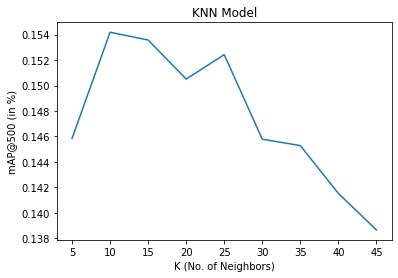

In [23]:
from matplotlib import pyplot as plt

# Load the Values of mAP@500 precomputed by me on Kaggle Kernel for KNN Model
k_values, map_values = pickle.load(open("./list/knn/k_map_list_knn.pkl","rb"))

map_max = max(map_values)
k_map_max = k_values[map_values.index(map_max)]

# Print Max value of mAP@500 (in %)
print("Max Value of mAP@500 (in %) is:", map_max, "for k:", k_map_max)

# Plot the Graph
plt.plot(k_values,map_values)
plt.title("KNN Model")
plt.xlabel("K (No. of Neighbors)")
plt.ylabel("mAP@500 (in %)")
plt.show()

### Calculation of mAP@500 score for $k$NN Model

In [24]:
%%time
# Calcuate mAP@500 for test Sample
mAP_at_tau = Evaluation.maptau(knn_model, common_users, test_util_dict, sampling_rate=0.3, tau=500)
print("---------------------------------")
print("mAPat500 for test sample is:", mAP_at_tau, "%")
print("---------------------------------")

Length of user_test_and_training:68388
Length of user sample:20516
1 0.0 %
10001 0.14833763166523334 %
20001 0.15692185261736744 %
20516 0.16250122951196716 %
---------------------------------
mAPat500 for test sample is: 0.16250122951196716 %
---------------------------------
CPU times: user 9.28 s, sys: 98.6 ms, total: 9.38 s
Wall time: 9.59 s


## SVD - Latent Factors Based Model

In its simplest form, a latent factor model decomposes the Rating/ Feedback matrix M into a latent feature space which relates users to items (and vice versa). This is usually achieved by factoring the matrix M as 
$M = U.S.Vt$ where **Matrix U is of shape(m,k), S is of shape(k,k) and Vt of shape(k,n) (by shape, i mean Order) where m = No. of users, n = No. of Songs and k = No. of latent factors associated with Users and Songs**. <br><br>
Here, Matrix U contains Latent Factors for the users (row wise) and Matrix Vt contains Latent Factors of the Songs (column wise) and then the Recommendation Matrix R is calculated as Product of Matrices U and Vt i.e $R = U.Vt$ such that **R is of shape(m,n)** and we call this Matrix, the Recommendation Matrix.
Now, Given a User $u$, We find the List (or Row) of Songs $R_{u}$ and Sort the Values of it in Decreasing Order and then we call it the Recommendation List containg Recommended Songs in Sorted Order of their Score calculated via SVD.
Finally, We Remove the Songs Already listened by User from our Recommendation List.


In [25]:
# Generate Feedback / Rating Matrix M for SVD
M = utility.gen_M()

In [26]:
%%time
# Create SVD Model Instance
svd_model = Recommenders.svd_recommender()
svd_model.create(M, train_util_dict , k=1300)

CPU times: user 5min 22s, sys: 13 s, total: 5min 35s
Wall time: 3min 43s


In [27]:
# Get Recommendations for a User
svd_model.recommend(test_users[4000])

,song_id,title,score
0,SOFOSTI12A6701D7BE,The Last Song,0.007911
1,SOYPRBR12A8C14396C,Mona Lisa (When The World Comes Down),0.007695
2,SOKOTYF12A8C13F2E7,Too Far Gone,0.007560
3,SOIPFGR12B0B8063CB,Drive Away,0.006776
4,SONXHLT12A8AE48546,October Song,0.005017
...,...,...,...
495,SOLMDRD12A8C132D16,Ciega_ Sordomuda,0.000937
496,SOHWNCK12A67020845,Used To Love Her,0.000937
497,SOOSVUB12A8C13B13F,"Aber Dich Gibt's Nur Einmal F\xc3\xbcr Mich""""",0.000937
498,SOPLVFB12A8C141022,Undantag,0.000936


### Tuning the Hyperparameter $k$ i.e No. of Latent Factors for SVD Model

A hyperparameter, $k$ (no. of latent factors) is involved with SVD Model. Now our Goal is to find the value of $k$ for which maP@500 score for SVD Model comes out to be maximum.
For this, I calculated mAP@500 score at different values of $k$ and noted the value of $k$ at which mAP@500 is max.<br>
The Max. Value of mAP@500 is acheived at $k=1300$ with $mAP@500=10.124$ (in %).

Max Value of mAP@500 (in %) is: 10.12416129008201 for k: 1300


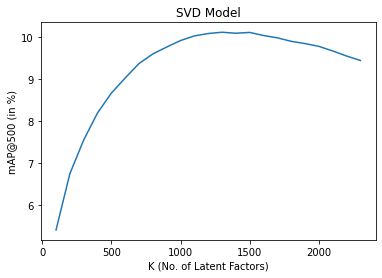

In [28]:
from matplotlib import pyplot as plt

# Load the Values of mAP@500 precomputed by me on Kaggle Kernel for SVD Model
k_values, map_values = pickle.load(open("./list/svd/k_map_list_svd.pkl","rb"))

map_max = max(map_values)
k_map_max = k_values[map_values.index(map_max)]

# Print Max value of mAP@500 (in %)
print("Max Value of mAP@500 (in %) is:", map_max, "for k:", k_map_max)

#Plot the Graph
plt.plot(k_values,map_values)
plt.title("SVD Model")
plt.xlabel("K (No. of Latent Factors)")
plt.ylabel("mAP@500 (in %)")
plt.show()

### Calculation of mAP@500 score for SVD Model

In [29]:
%%time
# Calcuate mAP@500 for test Sample
mAP_at_tau = Evaluation.maptau(svd_model, common_users, test_util_dict, sampling_rate=0.3, tau=500)
print("---------------------------------")
print("mAPat500 for test sample is:", mAP_at_tau, "%")
print("---------------------------------")

Length of user_test_and_training:68388
Length of user sample:20516
1 11.953183874204882 %
10001 9.923972849060076 %
20001 9.990921248911903 %
20516 9.988868009326358 %
---------------------------------
mAPat500 for test sample is: 9.988868009326358 %
---------------------------------
CPU times: user 53.4 s, sys: 1.83 s, total: 55.2 s
Wall time: 1min 7s


## Collaborative Filtering ( Memory CF )

Collaborative filtering involves collecting information from many users and then making predictions based on
some similarity measures between users and between items. This can be classified into user_user and item_item based models.
<br>
In **item_item based model**, it is assumed that songs that are often listened together by some users tend to be similar and are more likely to be listened together in future also by some other user i.e If Songs $S_{i}$ and $S_{j}$ are listened together by the users $U_{1}$, $U_{2}$ , ... $U_{n-1}$ and now a new user Un listens to a song $S_{i}$ , then there is very high probability that user Un will also listen to song $S_{j}$ as Both $S_{i}$ and $S_{j}$ have similar listening histories.
<br>
Similarly, **User_User based model**, it is assumed that users who have similar listening histories, i.e., have listened to the same songs in the past tend to have similar interests and will probably listen to the same songs i.e If users $U_{u}$ and $U_{v}$ listened together the songs $S_{1}$, $S_{2}$ , ... $S_{n-1}$ and now user Uu listens to a new song $S_{n}$ , then there is very high probability that user Uv will also listen to song Sn as Both $U_{u}$ and $U_{v}$ have similar listening histories.
<br>
Now, for both the Models, We need some similarity measure $w_{i, j}$ (for item item) and $w_{u, v}$ (for user user) to compare between two songs or between two users. One of the Similarity scores, can be Cosine similarity, but it weighs each of the users equally which is usually not the case.  A user should be weighted less if he has shown interest in many varieties of items (it shows that either he/she does not discern between songs based on their quality, or just likes to explore).
<br>
So, I have used two Similarity Measures namely:
1. **Jaccard Based Score:** Sorted Songs according to the Jaccard Index/ Score ( More Info [here](https://en.wikipedia.org/wiki/Jaccard_index) or given in the report of this project )
<br>
2. **Conditional Probability Score:** Sorted according to the Score obtained using Conditional Probability ( More Info [here](http://www.ke.tu-darmstadt.de/events/PL-12/papers/08-aiolli.pdf) or given in the report of this project )
<br>
One by One Implementation of the above measures into item_item CF and user_user CF Models have been given below:

### Item_Item_Jaccard_CF Model

In [30]:
import Rec as Recommenders
import importlib
importlib.reload(Recommenders)
# Create Item_Item_Jaccard_Prob Model Instance
song_sim_jaccard_model = Recommenders.cf_sim_recommender(type="item_item", method="jaccard")
song_sim_jaccard_model.create(train_util_dict)

In [31]:
%%time
# Get Recommendations for a User
song_sim_jaccard_model.recommend(test_users[40])

CPU times: user 1min 21s, sys: 1.34 s, total: 1min 22s
Wall time: 1min 28s


,song_id,title,score
0,SOKLRPJ12A8C13C3FE,The Scientist,1.202910
1,SOWEJXA12A6701C574,Fix You,1.109421
2,SONYKOW12AB01849C9,Secrets,0.999492
3,SOCVTLJ12A6310F0FD,Clocks,0.984298
4,SOPXKYD12A6D4FA876,Yellow,0.934155
...,...,...,...
495,SOAVWHY12AB017C6C0,Losing Touch,0.195036
496,SOEMUXL12A58A7B848,Reha,0.194938
497,SOODHLO12AF72A1980,The Joker,0.194718
498,SOQUJLT12A8C141F8A,My Life Would Suck Without You,0.194511


In [32]:
%%time
# Get Similar Songs for a Song
song_sim_jaccard_model.get_similar_items(test_songs[1080])

CPU times: user 834 ms, sys: 14.7 ms, total: 849 ms
Wall time: 887 ms


,song_id,title,score
0,SOHGFMT12A6D4FA66F,Red Rabbits (Album),0.185874
1,SOTCPQN12A6D4FA673,Girl Sailor (Album),0.180451
2,SOKZKDF12A6D4FA670,Turn On Me (Album),0.172185
3,SOVFFSK12A6BD55C96,Australia (Album),0.162371
4,SOSVTWI12A6D4FA672,Spilt Needles (Album),0.159696
...,...,...,...
9995,SOIWAFI12A6D4F722E,A Good Heart,0.000000
9996,SORPBJG12AB017EA14,Aero Zeppelin,0.000000
9997,SOEBPPM12AB0187E1C,Sunshine Of Your Love,0.000000
9998,SOKBSZY12AB017BD8B,When In Rome,0.000000


### Calculation of mAP@500 score for Item_Item_Jaccard_CF Model

In [33]:
# Importing Pre Computed R Matrix for evaluation of Item_Item_Jaccard_Eval_CF Model
R_item_jaccard = pickle.load(open("./data/item_item/R_item_jaccard.pkl","rb"))

In [34]:
%%time
# Create the Item_Item_Jaccard_Eval_CF Model for Evaluation
song_sim_jaccard_eval_model = Recommenders.cf_recommender(type="item_item", method="jaccard")
song_sim_jaccard_eval_model.create(M, train_util_dict, R=R_item_jaccard)

# Calcuate mAP@500 for test Sample
mAP_at_tau = Evaluation.maptau(song_sim_jaccard_eval_model, common_users, test_util_dict, sampling_rate=0.3, tau=500)
print("---------------------------------")
print("mAPat500 for test sample is:", mAP_at_tau, "%")
print("---------------------------------")

Length of user_test_and_training:68388
Length of user sample:20516
1 2.247618120731598 %
10001 14.442092575568658 %
20001 14.46629331958562 %
20516 14.48872617213902 %
---------------------------------
mAPat500 for test sample is: 14.48872617213902 %
---------------------------------
CPU times: user 24.7 s, sys: 3.64 s, total: 28.4 s
Wall time: 36 s


### Item_Item_Prob_CF Model

In [35]:
import Rec as Recommenders
import importlib
importlib.reload(Recommenders)
# Create Item_Item_Prob_CF Similarity Model Instance
song_sim_prob_model = Recommenders.cf_sim_recommender(type="item_item", method="prob")
song_sim_prob_model.create(train_util_dict, A=0.85, Q=1)

In [36]:
%%time
#Get Recommendations for a user
song_sim_prob_model.recommend(test_users[87])

CPU times: user 51.8 s, sys: 863 ms, total: 52.7 s
Wall time: 1min 2s


,song_id,title,score
0,SOYHKYO12AB018224C,My Maudlin Career,3.252165
1,SOFUYTQ12AC90719F0,Happy New Year,3.188823
2,SOCFPBP12AB0182D2B,Swans,3.154597
3,SOGXWGC12AF72A8F9A,Leave The Bourbon On The Shelf,3.147676
4,SOZFHVL12AB0182D22,You Told A Lie,3.147258
...,...,...,...
495,SODHJHX12A58A7D24C,Cold Desert,1.497701
496,SOQXTDZ12AF729F8B4,The List,1.496984
497,SOYMQKD12A6310D7EB,Take The Box,1.495764
498,SORXTFK12AB018A177,Blake\x19s View,1.494797


In [37]:
%%time
# Get Similar Songs for a Song
song_sim_prob_model.get_similar_items(test_songs[440])

CPU times: user 626 ms, sys: 11.3 ms, total: 638 ms
Wall time: 668 ms


,song_id,title,score
0,SOPJLOZ12A8C132642,Lafayette Blues,0.267410
1,SOOYIHH12AB018C2C7,"Let's Build A Home (Album Version)""""",0.180568
2,SOCVHMA12AB0185829,We Are Going To Be Friends (Live),0.140585
3,SODTTCN12A81C21907,Good To Me,0.112257
4,SOLCTNA12AB0185F52,Nobody But You,0.106177
...,...,...,...
9995,SOEBPPM12AB0187E1C,Sunshine Of Your Love,0.000000
9996,SOYJUXS12AC95F02EF,I Swear This Time I Mean It (Album Version),0.000000
9997,SOKBSZY12AB017BD8B,When In Rome,0.000000
9998,SOWUVOQ12A58A80BD7,Magic (LP Version),0.000000


### Tuning the Hyperparameters $A$ (Similarity Function Parameter) and $Q$ (Scoring Function Parameter) i.e  for Item_Item_Prob Model

Hyperparameter, $A$ and $Q$ are involved with Item_Item_Prob Model. Now our Goal is to find the value of $A$ and $Q$ for which maP@500 score for Item_Item_Prob Model comes out to be maximum.

#### Tuning Hyperparameter Q 

For this, I calculated mAP@500 score for Item_Item_Prob Model at different values of $Q$ keeping $A$ as constant being equal to 0, 0.5 and 1 (corner values for A as $ 0<=A<=1 $) and noted the value of $Q$ (keeping $A$ constant) at which mAP@500 is max.<br>
The Max. Value of mAP@500 is acheived at $Q=1$ for $A=0.5$ with $mAP@500=14.723$ (in %).

Max Value of mAP@500 (in %) at A=0 is: 8.938716173257392 for Q: 1
Max Value of mAP@500 (in %) at A=0.5 is: 14.723728738262002 for Q: 1
Max Value of mAP@500 (in %) at A=1 is: 14.544515334276923 for Q: 4


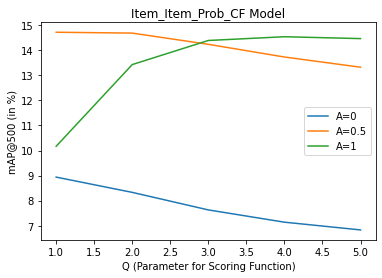

In [38]:
from matplotlib import pyplot as plt

# Load the Values of mAP@500 precomputed by me on Kaggle Kernel for Item_Item_Prob_CF Model Model
Q_values_A0, map_values_A0 = pickle.load(open("./list/item_item_prob/AQ_map_list_item_prob_A0.pkl","rb"))
Q_values_A05, map_values_A05 = pickle.load(open("./list/item_item_prob/AQ_map_list_item_prob_A0.5.pkl","rb"))
Q_values_A1, map_values_A1 = pickle.load(open("./list/item_item_prob/AQ_map_list_item_prob_A1.pkl","rb"))

map_max_A0 = max(map_values_A0)
Q_map_max_A0 = Q_values_A0[map_values_A0.index(map_max_A0)]

# Print Max value of mAP@500 (in %) at A=0
print("Max Value of mAP@500 (in %) at A=0 is:", map_max_A0, "for Q:", Q_map_max_A0)

map_max_A05 = max(map_values_A05)
Q_map_max_A05 = Q_values_A05[map_values_A05.index(map_max_A05)]

# Print Max value of mAP@500 (in %)at A=0.5
print("Max Value of mAP@500 (in %) at A=0.5 is:", map_max_A05, "for Q:", Q_map_max_A05)

map_max_A1 = max(map_values_A1)
Q_map_max_A1 = Q_values_A1[map_values_A1.index(map_max_A1)]

# Print Max value of mAP@500 (in %) at A=1
print("Max Value of mAP@500 (in %) at A=1 is:", map_max_A1, "for Q:", Q_map_max_A1)

# Plot the Graph
plt.plot(Q_values_A0, map_values_A0, label='A=0')
plt.plot(Q_values_A05, map_values_A05, label='A=0.5')
plt.plot(Q_values_A1, map_values_A1, label='A=1')
plt.title("Item_Item_Prob_CF Model")
plt.xlabel("Q (Parameter for Scoring Function)")
plt.ylabel("mAP@500 (in %)")
plt.legend()
plt.show()

#### Tuning Hyperparameter A 

For this, I calculated mAP@500 score for Item_Item_Prob at different values of $A$ keeping $Q$ as constant being equal to 1 and 4 (corner values for Q for which mAP@500 was maximum for constant $A$) and noted the value of $A$ (keeping $Q$ constant) at which mAP@500 is max.<br>
The Max. Value of mAP@500 is acheived at $A=0.85$ for $Q=4$ with $mAP@500=15.080$ (in %).

Max Value of mAP@500 (in %) at Q=1 is: 14.74604423601075 for A: 0.55
Max Value of mAP@500 (in %) at Q=4 is: 15.080580555134441 for A: 0.8500000000000001


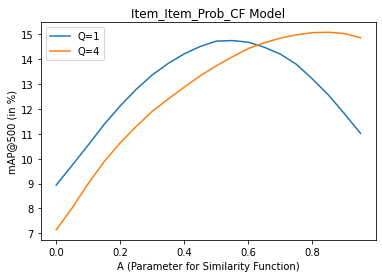

In [39]:
from matplotlib import pyplot as plt

# Load the Values of mAP@500 precomputed by me on Kaggle Kernel for Item_Item_Prob_CF Model Model
A_values_Q1, map_values_Q1 = pickle.load(open("./list/item_item_prob/AQ_map_list_item_prob_Q1.pkl","rb"))
A_values_Q4, map_values_Q4 = pickle.load(open("./list/item_item_prob/AQ_map_list_item_prob_Q4.pkl","rb"))

map_max_Q1 = max(map_values_Q1)
A_map_max_Q1 = A_values_Q1[map_values_Q1.index(map_max_Q1)]

# Print Max value of mAP@500 (in %) at Q=1
print("Max Value of mAP@500 (in %) at Q=1 is:", map_max_Q1, "for A:", A_map_max_Q1)

map_max_Q4 = max(map_values_Q4)
A_map_max_Q4 = A_values_Q4[map_values_Q4.index(map_max_Q4)]

# Print Max value of mAP@500 (in %) at Q=4
print("Max Value of mAP@500 (in %) at Q=4 is:", map_max_Q4, "for A:", A_map_max_Q4)

# Plot the Graph
plt.plot(A_values_Q1, map_values_Q1, label='Q=1')
plt.plot(A_values_Q4, map_values_Q4, label='Q=4')
plt.title("Item_Item_Prob_CF Model")
plt.xlabel("A (Parameter for Similarity Function)")
plt.ylabel("mAP@500 (in %)")
plt.legend()
plt.show()

### Calculation of mAP@500 score for Item_Item_Prob_CF Model

In [40]:
# Importing Pre Computed R Matrix for evaluation of Item_Item_Prob_Eval_CF Model
R_item_prob_A085Q4 = pickle.load(open("./data/item_item/R_item_prob_A0.85Q4.pkl","rb"))

In [41]:
%%time
# Create Item_Item_Prob_Eval_CF Similarity Model Instance
song_sim_prob_eval_model = Recommenders.cf_recommender(type="item_item", method="prob")
song_sim_prob_eval_model.create(M, train_util_dict, R=R_item_prob_A085Q4, A=0.85, Q=1)

# Calcuate mAP@500 for test Sample
mAP_at_tau = Evaluation.maptau(song_sim_prob_eval_model, common_users, test_util_dict, sampling_rate=0.3, tau=500)
print("---------------------------------")
print("mAPat500 for test sample is:", mAP_at_tau, "%")
print("---------------------------------")

Length of user_test_and_training:68388
Length of user sample:20516
1 2.2811295725401832 %
10001 14.813566961485181 %
20001 14.887188978398763 %
20516 14.909024207833758 %
---------------------------------
mAPat500 for test sample is: 14.909024207833758 %
---------------------------------
CPU times: user 25.4 s, sys: 2.77 s, total: 28.2 s
Wall time: 32.6 s


### User_User_Jaccard_CF Model

In [42]:
# Creating a Random Subset (2%) of Dataset for Training & Testing User_User CF Models
newtrain_data = data.sample(frac=0.02, random_state=0)
newtrain_data

,user_id,song_id,title,listen_count
1181498,4b96ba3b9768637a915b9cc5c26f7bf4cb29ba70,SOHLLRP12A6701F2F4,Under The Bridge (Album Version),9
113995,67f01613b368c58c44949ace64dc17eb7b5a407e,SODPPBT12A8C141D90,Closer,1
1071914,4b1ca9ef64bd1e61e79fde143c3aa84fcb468a14,SOCUQMK12A8C135B78,Cannonball,4
1871428,a84df449cbbd943b246030425a146f91222d8968,SOOOICO12A8C139457,Old Song,1
941931,0a6c1c6c88bbd53d04806d022cf45e5e45cd0c24,SODCNJX12A6D4F93CB,Jamaica Roots II(Agora E Sempre),1
...,...,...,...,...
812648,940ed4a83f5a3f9ac29d55a7d5b2e3b9cc55c3c5,SOCYOTN12A8C13A4B1,My Happy Ending,1
951118,3ad8bbb05e77171ab8aa13f520cb3d9a2f71d891,SOFGJCW12AF72A812D,Already Gone,1
980151,30d9cf518bce7019bc7dd6908c444c3f6fbdb3db,SOOWXAQ12AB0188996,Docking Bay 94,1
1707429,6b13b3cb83f88bbe978bf8dc3679f0736343c2b0,SOLRGVL12A8C143BC3,Bulletproof,9


In [43]:
# Create util_dict for newtrain_data for User_User_CF Models
newtrain_util_dict = utility.gen_util_dict(dataset_list=[newtrain_data], dataset_names_list=["newtrain_data"])
newtrain_util_dict = newtrain_util_dict["newtrain_data"]

# Create Ranking Matrix new_M for newtrain_data for User_User_CF Models
new_M = utility.gen_M(newtrain_data, dataset_name="newtrain_data")

# Get pre computed test sample (common with other models) for User_User_CF Models
newtest_sample = pickle.load(open("./data/newtest_sample.pkl","rb"))
print("Length of Test Sample for User_User_CF Models:",len(newtest_sample))

# Get pre computed test_u2s mapping for newtest_sample for User_User_CF Models
newtest_u2s = pickle.load(open("./data/newtest_u2s.pkl","rb"))

Length of Test Sample for User_User_CF Models: 7761


In [44]:
import Rec as Recommenders
import importlib
importlib.reload(Recommenders)

# Create User_User_Jaccard_CF Similarity Model Instance
user_sim_jaccard_model = Recommenders.cf_sim_recommender(type="user_user", method="jaccard")
user_sim_jaccard_model.create(train_util_dict)

In [45]:
%%time
#Get Recommendations for a user
user_sim_jaccard_model.recommend(test_users[190])

CPU times: user 2.39 s, sys: 54.3 ms, total: 2.44 s
Wall time: 2.76 s


,song_id,title,score
0,SOAUWYT12A81C206F1,Undo,22.277953
1,SOBONKR12A58A7A7E0,"You're The One""""",19.038643
2,SOFRQTD12A81C233C0,Sehr kosmisch,18.777527
3,SOEGIYH12A6D4FC0E3,Horn Concerto No. 4 in E flat K495: II. Romanc...,17.813121
4,SOSXLTC12AF72A7F54,Revelry,17.806683
...,...,...,...
495,SOXHPVI12A6D4F903A,"It Wasn't Me""""",1.025084
496,SOYPWKK12A8C136494,Ready_ Steady_ Go (Album Version),1.024302
497,SOTJDDY12AB017DC5B,"I'm In Miami Bitch""""",1.024272
498,SOMMMFT12A67ADC119,Temperature (Album Version),1.022082


In [46]:
%%time
# Get Similar Users for a User
user_sim_jaccard_model.get_similar_items(test_users[56])

CPU times: user 3.14 s, sys: 53.2 ms, total: 3.19 s
Wall time: 3.5 s


,user_id,score
0,ba84933e06baa936ed69b4240deb9bbbc8c26d63,0.195652
1,d408a12db28ca42c2fbe288d6d50ce71a4f457ed,0.166667
2,06529e2d4c86b50d4425d844220541ec99aa562e,0.155556
3,150ed31f94be90359dc5f59b6de72f54ad9e38f8,0.142857
4,9f5991bb8cf794d90dd88a21da70febabdf91c8a,0.133333
...,...,...
12339,4fa22edbfd4fcebb74956c8701e20b15fa1fc3e8,0.002439
12340,1aa4fd215aadb160965110ed8a829745cde319eb,0.002268
12341,a15075a926c1998d91940f118342ba8356efc7d4,0.002257
12342,b04e41133dd3d30a5631cc8589a1eadd48a8bd53,0.002222


### Calculation of mAP@500 score for User_User_Jaccard_CF Model

In [47]:
# Importing Pre Computed R Matrix for evaluation of User_User_Jaccard_Eval_CF Model
newR_user_jaccard = pickle.load(open("./data/new_user_user/newR_user_jaccard.pkl","rb"))

In [48]:
%%time
# Create User_User_Jaccard_Eval_CF Similarity Model Instance
user_sim_jaccard_eval_model = Recommenders.cf_recommender(type="user_user", method="jaccard")
user_sim_jaccard_eval_model.create(new_M, newtrain_util_dict, R=newR_user_jaccard)

# Calcuate mAP@500 for test Sample
mAP_at_tau = Evaluation.maptau(user_sim_jaccard_eval_model, newtest_sample, {'u2s': newtest_u2s}, sampling_rate=1, tau=500)
print("---------------------------------")
print("mAPat500 for test sample is:", mAP_at_tau, "%")
print("---------------------------------")

Length of user_test_and_training:7761
Length of user sample:7761
1 0.04995004995004995 %
7761 0.3853756924059717 %
---------------------------------
mAPat500 for test sample is: 0.3853756924059717 %
---------------------------------
CPU times: user 4.18 s, sys: 157 ms, total: 4.33 s
Wall time: 4.65 s


### User_User_Prob_CF Model

In [49]:
# Create User_User_Prob_CF Similarity Model Instance
user_sim_prob_model = Recommenders.cf_sim_recommender(type="user_user", method="prob")
user_sim_prob_model.create(train_util_dict, A=0.5, Q=1)

In [50]:
%%time
#Get Recommendations for a user
user_sim_prob_model.recommend(test_users[89])

CPU times: user 2.3 s, sys: 43.8 ms, total: 2.35 s
Wall time: 3.18 s


,song_id,title,score
0,SOBONKR12A58A7A7E0,"You're The One""""",43.887066
1,SOAUWYT12A81C206F1,Undo,41.703039
2,SOSXLTC12AF72A7F54,Revelry,35.397879
3,SOEGIYH12A6D4FC0E3,Horn Concerto No. 4 in E flat K495: II. Romanc...,33.971951
4,SOHTKMO12AB01843B0,Catch You Baby (Steve Pitron & Max Sanna Radio...,32.415250
...,...,...,...
495,SOMCWAZ12A67ADBCE3,In The Waiting Line,1.899017
496,SOLQXDJ12AB0182E47,Yes,1.893435
497,SOHMJJQ12AF72AD2A2,Slow Dancing In A Burning Room,1.889924
498,SOYRJTL12A67AD9551,My List,1.887002


In [51]:
%%time
# Get Similar User for a User
user_sim_prob_model.get_similar_items(test_users[45])

CPU times: user 1.45 s, sys: 17 ms, total: 1.47 s
Wall time: 1.59 s


,user_id,score
0,ca30555363881683c41b24389b8f1e468c01c6b4,0.500000
1,6f1ce98898ebb8fb94223a96a4bd1fcd137108c8,0.500000
2,3d0182d96be2ba26aa3d419583824a81254eb69f,0.408248
3,17017c985eb7467bf763306de691fb67ecb01f9b,0.408248
4,1865e60449c4edbc0b9551777b95ea08e1373651,0.408248
...,...,...
699,212092cf656fb03828351a6e6fda32a73ebb7ad3,0.051164
700,0abc7b26e61609909c5cd8dec4668b9c9cdfdd3b,0.048224
701,656684e0c8cd25284cbc29715b3669fd33018d1d,0.046324
702,0720ca8f3cc2d0c0c126e784b846785536ddefbc,0.046029


### Tuning the Hyperparameters $A$ (Similarity Function Parameter) and $Q$ (Scoring Function Parameter) i.e  for User_User_Prob Model

Hyperparameter, $A$ and $Q$ are involved with User_User_Prob Model. Now our Goal is to find the value of $A$ and $Q$ for which maP@500 score for User_User_Prob Model comes out to be maximum.

#### Tuning Hyperparameter Q 

For this, I calculated mAP@500 score for User_User_Prob Model at different values of $Q$ keeping $A$ as constant being equal to 0, 0.5 and 1 (corner values for A as $ 0<=A<=1 $) and noted the value of $Q$ (keeping $A$ constant) at which mAP@500 is max.<br>
The Max. Value of mAP@500 is acheived at $Q=1$ for $A=0.5$ with $mAP@500=0.3916$ (in %).

Max Value of mAP@500 (in %) at A=0 is: 0.37544780466619465 for Q: 1
Max Value of mAP@500 (in %) at A=0.5 is: 0.3916379794288577 for Q: 1
Max Value of mAP@500 (in %) at A=1 is: 0.3583087411879638 for Q: 1


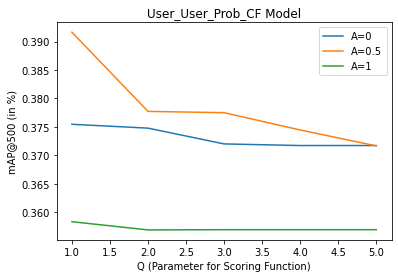

In [52]:
from matplotlib import pyplot as plt

# Load the Values of mAP@500 precomputed by me on Kaggle Kernel for KNN Model
Q_values_A0, map_values_A0 = pickle.load(open("./list/new_user_user_prob/new_AQ_map_list_user_prob_A0.pkl","rb"))
Q_values_A05, map_values_A05 = pickle.load(open("./list/new_user_user_prob/new_AQ_map_list_user_prob_A0.5.pkl","rb"))
Q_values_A1, map_values_A1 = pickle.load(open("./list/new_user_user_prob/new_AQ_map_list_user_prob_A1.pkl","rb"))

map_max_A0 = max(map_values_A0)
Q_map_max_A0 = Q_values_A0[map_values_A0.index(map_max_A0)]

# Print Max value of mAP@500 (in %) at A=0
print("Max Value of mAP@500 (in %) at A=0 is:", map_max_A0, "for Q:", Q_map_max_A0)

map_max_A05 = max(map_values_A05)
Q_map_max_A05 = Q_values_A05[map_values_A05.index(map_max_A05)]

# Print Max value of mAP@500 (in %) at A=0.5
print("Max Value of mAP@500 (in %) at A=0.5 is:", map_max_A05, "for Q:", Q_map_max_A05)

map_max_A1 = max(map_values_A1)
Q_map_max_A1 = Q_values_A1[map_values_A1.index(map_max_A1)]

# Print Max value of mAP@500 (in %) at A=1
print("Max Value of mAP@500 (in %) at A=1 is:", map_max_A1, "for Q:", Q_map_max_A1)

# Plot the Graph
plt.plot(Q_values_A0, map_values_A0, label='A=0')
plt.plot(Q_values_A05, map_values_A05, label='A=0.5')
plt.plot(Q_values_A1, map_values_A1, label='A=1')
plt.title("User_User_Prob_CF Model")
plt.xlabel("Q (Parameter for Scoring Function)")
plt.ylabel("mAP@500 (in %)")
plt.legend()
plt.show()

#### Tuning Hyperparameter A 

For this, I calculated mAP@500 score for User_User_Prob Model at different values of $A$ keeping $Q$ as constant being equal to 1 (corner values for Q for which mAP@500 was maximum for constant $A$) and noted the value of $A$ (keeping $Q$ constant) at which mAP@500 is max.<br>
The Max. Value of mAP@500 is acheived at $A=0.5$ for $Q=1$ with $mAP@500=0.3916$ (in %).

Max Value of mAP@500 (in %) at Q=1 is: 0.3916379794288577 for A: 0.5


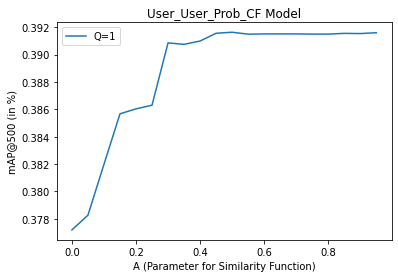

In [53]:
from matplotlib import pyplot as plt

# Load the Values of mAP@500 precomputed by me on Kaggle Kernel for Similarity_Item_Item Model
A_values_Q1, map_values_Q1 = pickle.load(open("./list/new_user_user_prob/new_AQ_map_list_user_prob_Q1.pkl","rb"))

map_max_Q1 = max(map_values_Q1)
A_map_max_Q1 = A_values_Q1[map_values_Q1.index(map_max_Q1)]

# Print Max value of mAP@500 (in %) at Q=1
print("Max Value of mAP@500 (in %) at Q=1 is:", map_max_Q1, "for A:", A_map_max_Q1)

# Plot the Graph
plt.plot(A_values_Q1, map_values_Q1, label='Q=1')
plt.title("User_User_Prob_CF Model")
plt.xlabel("A (Parameter for Similarity Function)")
plt.ylabel("mAP@500 (in %)")
plt.legend()
plt.show()

### Calculation of mAP@500 score for User_User_Prob_CF Model

In [55]:
# Importing Pre Computed R Matrix for evaluation of User_User_Prob_Eval_CF Model
newR_user_prob_A05Q1 = pickle.load(open("./data/new_user_user/newR_user_prob_A0.5Q1.pkl","rb"))

In [57]:
%%time
# Create User_User_Prob_Eval_CF Similarity Model Instance
user_sim_prob_eval_model = Recommenders.cf_recommender(type="user_user", method="prob")
user_sim_prob_eval_model.create(new_M, newtrain_util_dict, R=newR_user_prob_A05Q1, A=0.5, Q=1)

# Calcuate mAP@500 for test Sample
mAP_at_tau = Evaluation.maptau(user_sim_prob_eval_model, newtest_sample, {'u2s': newtest_u2s}, sampling_rate=1, tau=500)
print("---------------------------------")
print("mAPat500 for test sample is:", mAP_at_tau, "%")
print("---------------------------------")

Length of user_test_and_training:7761
Length of user sample:7761
1 0.04995004995004995 %
7761 0.3916379794288571 %
---------------------------------
mAPat500 for test sample is: 0.3916379794288571 %
---------------------------------
CPU times: user 3.75 s, sys: 133 ms, total: 3.89 s
Wall time: 4.02 s


## Results

To Compare the Different Models Discussed Above, I have used a common test sample (generated randomly with sample rate = 0.3 (i.e 30%) from the set containing users and songs common between train and test set). It contains about **21k unique users and 10k unique songs common among train and test test.** Note that the test sample must contain users common between test and train set  All of the Models are tested on Kaggle Kernel Online due to limited processing power and RAM in our local system.<br>

Out of the Different Models Discussed Above, Item_Item_CF_Prob Model has performed best with $mAP@500=15.08$(in %).<br>

A Graphical Comparison between Different Models is is Given Below (*Note that I haven't included User_User_CF Models in this comparison because they both were tested on a different (very smaller) test sample due to availability of limited processing power and RAM in our local system and even in Kaggle Kernel Online*).

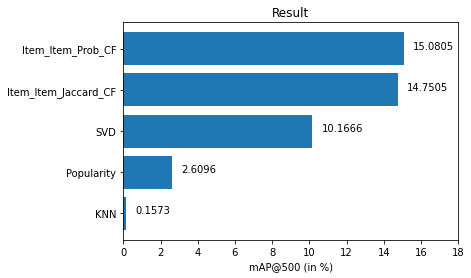

In [58]:
from matplotlib import pyplot as plt

# Load the Values of mAP@500 precomputed by me on Kaggle Kernel for Different Models
models, map_values = pickle.load(open("./list/result/models_map_list.pkl","rb"))

# Don't Compare User_User_CF Models with Rest of the Models
models = models[:len(models)-2]
map_values = map_values[:len(map_values)-2]

# Plot the Bar Graph
plt.barh(models, map_values)
for index, value in enumerate(map_values):
    plt.text(value+0.5, index, str(value))

# Set xlimit and Title for the Graph
plt.xlim(0,18)
plt.xlabel("mAP@500 (in %)")
plt.title("Result")
plt.show()

Since User_User_CF Models were trained and tested on a different (a very smaller) dataset/ test sample because of the limited computational power available on our local system and on Kaggle Kernel Online. So, I have compared them seperately below with each other.
<br>
It is due to the smaller training dataset, User_User_CF Models are having such a low $mAP@500$ (in %) scores.

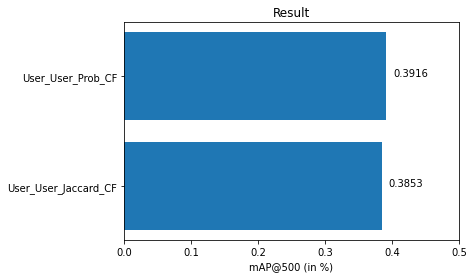

In [59]:
from matplotlib import pyplot as plt

# Load the Values of mAP@500 precomputed by me on Kaggle Kernel for Different Models
models, map_values = pickle.load(open("./list/result/models_map_list.pkl","rb"))

# Compare Only User_User_CF Models with themselves
models = models[len(models)-2:]
map_values = map_values[len(map_values)-2:]

# Plot the Bar Graph
plt.barh(models, map_values)
for index, value in enumerate(map_values):
    plt.text(value+0.01, index, str(value))

# Set xlimit and Title for the Graph
plt.xlim(0,0.5)
plt.xlabel("mAP@500 (in %)")
plt.title("Result")
plt.show()

### Results from the Data Contained in Rating Matrix M

Min, Max, Mean and Median for users per song and songs per user has been given below. All of it, is derived from Rating Matrix M.
<br>
We can see that the **Matrix M is highly sparse (contains about 0.2% non-zeros Entries)** this makes the computation and prediction a very difficult task. Also, the results suggests that **Each Song in dataset has atleast 33 listeners and almost half of the songs have about 100 listeners. While, Each User in dataset have listened to atleast 1 song and almost half of the users have listened to about 13 songs.** These statistics helped our Collaborative Filtering Model fit well with the Train Data and for it's maximum mAP@500 Score.

In [60]:
# Generate Rating Matrix M using utility function
M = utility.gen_M()
M = M.toarray()

In [61]:
# Density of Matrix M
print("Density of Matrix M:", np.mean(M)*100,"%")

# Songs per User Column Matrix
s = np.sum(M,axis=1)

# Users per Song Row Matrix
r = np.sum(M,axis=0)

# Creating DataFrame for Results of Rating Matrix M
row = [[min(s),max(s),np.mean(s),np.median(s)],[min(r),max(r),np.mean(r),np.median(r)]]
column = ['Min','Max','Mean','Median']
index = ['songs per user','users per song']
result_M = pd.DataFrame(row, columns=column, index=index)
result_M

Density of Matrix M: 0.21023848094046116 %


,Min,Max,Mean,Median
songs per user,1.0,570.0,21.023849,13.0
users per song,33.0,6612.0,159.999893,99.0


### Results from Sampling Rate vs mAP@500 Score

This Visulisation helps in analyzing our Models for new users which it hasn’t seen before. Clearly, mAP@500 score almost remains consistent with each of the models and varies very slightly in magnitude. Item_Item_CF models still results in max mAP@500 score even with different and increasing sample rate, followed by SVD and Popularity Model.


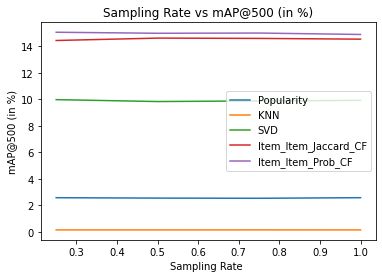

In [62]:
from matplotlib import pyplot as plt

# Load the Values of mAP@500 precomputed by me on Kaggle Kernel for Different Models
prec_values, map_values_popularity = pickle.load(open("./list/popularity/perc_map_list_popularity.pkl","rb"))
_, map_values_knn = pickle.load(open("./list/knn/perc_map_list_knn.pkl","rb"))
_, map_values_svd = pickle.load(open("./list/svd/perc_map_list_svd.pkl","rb"))
_, map_values_item_jaccard = pickle.load(open("./list/item_item_jaccard/perc_map_list_item_jaccard.pkl","rb"))
_, map_values_item_prob = pickle.load(open("./list/item_item_prob/perc_map_list_item_prob.pkl","rb"))

# Plot the Graph
plt.plot(prec_values, map_values_popularity, label='Popularity')
plt.plot(prec_values, map_values_knn, label='KNN')
plt.plot(prec_values, map_values_svd, label='SVD')
plt.plot(prec_values, map_values_item_jaccard, label='Item_Item_Jaccard_CF')
plt.plot(prec_values, map_values_item_prob, label='Item_Item_Prob_CF')
plt.title("Sampling Rate vs mAP@500 (in %)")
plt.xlabel("Sampling Rate ")
plt.ylabel("mAP@500 (in %)")
plt.legend()
plt.show()

Since User_User_CF Models were trained and tested on a different (a very smaller) dataset/ test sample because of the limited computational power available on our local system and on Kaggle Kernel Online. So, We are comparing them below with each other.
<br>
It is due to the smaller training dataset, User_User_CF Models are having such a low $mAP@500$ (in %) scores.
<br>
User_User_CF also performed consistent with the sampling rate and generalised well with the unseen examples but we can see a slight dip in both the Models near sample rate = 0.75.

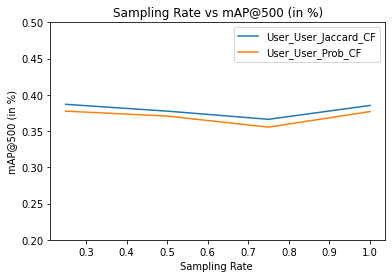

In [63]:
from matplotlib import pyplot as plt

# Load the Values of mAP@500 precomputed by me on Kaggle Kernel for Different Models
prec_values, map_values_user_prob = pickle.load(open("./list/new_user_user_prob/new_perc_map_list_user_prob.pkl","rb"))
_, map_values_user_jaccard = pickle.load(open("./list/new_user_user_jaccard/new_perc_map_list_user_jaccard.pkl","rb"))

# Plot the Graph
plt.plot(prec_values, map_values_user_jaccard, label='User_User_Jaccard_CF')
plt.plot(prec_values, map_values_user_prob, label='User_User_Prob_CF')
plt.title("Sampling Rate vs mAP@500 (in %)")
plt.xlabel("Sampling Rate ")
plt.ylabel("mAP@500 (in %)")
plt.ylim(0.2, 0.5)
plt.legend()
plt.show()

## Conclusion

I find this project as an opportunity to practice theory that I have learnt in various online courses related to ML and AI, to do some implementation and to try to get a better understanding of a real world problem: Music Recommendation. The MSD is a huge Dataset and handling it is a difficult problem, so, By manipulating the dataset, changing the learning set and testing set, changing some parameters of the problem and analyzing the result, I learnt a lot of practicing skills. The Music Recommender System is itself a Research Oriented, Wide, Open and Complicated Domain. I also got to realize that building it is not a trivial task. Its large scale dataset makes it difficult in many aspects. Firstly, recommending Hundreds of correct songs out of Hundreds of millions Songs for different users is not an easy task to get a high precision which is evident by the above result not being better than 15 % (which is relatively good but can be better). Secondly, the metadata includes huge information and when exploring it, it is difficult to extract relevant features for a song and its memory and CPU intensive. All these difficulties due to the data and to the system itself make it more challenging and also more attractive Domain for Researchers. But anyways, I learnt a lot from this project and it was a great experience in learning and working for this problem.

**Thank You<br>
Umesh Yadav<br>
2018UCS0078<br>
IIT JMU**